# Модель оттока клиентов банка

Из «Бета-Банка» ежемесячно стали уходить клиенты. Количество ушедших клиентов небольшое, но заметное. Маркетинговая служба банка сделала расчеты, которые показали, что сохранять текущих клиентов дешевле, чем привлекать новых.

*Компания поставила задачу*: нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Цель исследования**: на основе исторических данных о поведении клиентов и расторжении договоров построить модель, которая будет предсказывать уход клиента.

*Критерии для построения модели*: необходимо выбрать модель с предельно большим значением *F1*-меры (не менее 0.59). Дополнительно следует замерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

*Исторические данные о поведении клиентов и расторжении договоров с банком содержат следующие признаки:*

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента (*целевой признак*)

Источник данных для проекта: Яндекс.Практикум.
Оригинальный источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1. Подготовка данных

### 1.1. Изучение данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
# зададим отображение количества столбцов датафрейма
pd.options.display.max_columns = 100

# зададим формат отображения дробных чисел
pd.options.display.float_format = '{:,.2f}'.format

Загрузим данные, посмотрим общую информацию и выведем на экран первые 10 строк:

In [4]:
df = pd.read_csv('C:\\Users\\Public\\Documents\\datasets\\Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0
5,6,15574012,Chu,645,Spain,Male,44,8.00,"113,755.78",2,1,0,"149,756.71",1
6,7,15592531,Bartlett,822,France,Male,50,7.00,0.00,2,1,1,"10,062.80",0
7,8,15656148,Obinna,376,Germany,Female,29,4.00,"115,046.74",4,1,0,"119,346.88",1
8,9,15792365,He,501,France,Male,44,4.00,"142,051.07",2,0,1,"74,940.50",0
9,10,15592389,H?,684,France,Male,27,2.00,"134,603.88",1,1,1,"71,725.73",0


Выведем описательную статистику по числовым данным датафрейма:

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,"10,000.00","5,000.50","2,886.90",1.00,"2,500.75","5,000.50","7,500.25","10,000.00"
CustomerId,"10,000.00","15,690,940.57","71,936.19","15,565,701.00","15,628,528.25","15,690,738.00","15,753,233.75","15,815,690.00"
CreditScore,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,"9,091.00",5.00,2.89,0.00,2.00,5.00,7.00,10.00
Balance,"10,000.00","76,485.89","62,397.41",0.00,0.00,"97,198.54","127,644.24","250,898.09"
NumOfProducts,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"


Посмотрим на соотношение мужчин и женщин в данных по странам (в процентных пунктах):

In [7]:
df.pivot_table(index='Geography', columns = 'Gender', 
               values='RowNumber', aggfunc = 'count', margins = True, margins_name = 'Total')/len(df)*100

Gender,Female,Male,Total
Geography,,,
France,22.61,27.53,50.14
Germany,11.93,13.16,25.09
Spain,10.89,13.88,24.77
Total,45.43,54.57,100.00


Рассмотрим данные о доле клиентов с кредитными картами:

In [8]:
print('Доля держателей кредитных карт среди женщин:', df.query('Gender == "Female"')['HasCrCard'].mean())
print('Доля держателей кредитных карт среди мужчин:', df.query('Gender == "Male"')['HasCrCard'].mean())

Доля держателей кредитных карт среди женщин: 0.7026194144838213
Доля держателей кредитных карт среди мужчин: 0.7078981125160344


Рассмотрим данные о доле активных клиентов банка:

In [9]:
print('Доля активных клиентов среди женщин:', df.query('Gender == "Female"')['IsActiveMember'].mean())
print('Доля активных клиентов среди мужчин:', df.query('Gender == "Male"')['IsActiveMember'].mean())

Доля активных клиентов среди женщин: 0.5027514858023333
Доля активных клиентов среди мужчин: 0.5253802455561664


Посмотрим, как распределены доли ушедших клиентов среди мужчин и женщин (в процентных пунктах):

In [10]:
df.pivot_table(index='Gender', values='Exited', aggfunc = 'mean', margins = True, margins_name = 'Total')*100

,Exited
Gender,
Female,25.07
Male,16.46
Total,20.37


**Выводы**

Датафрейм содержит 10 тыс. записей о клиентах из трёх стран: 

- Франция (50,1% клиентов), 
- Германия (25,1% клиентов), 
- Испания (24,8% клиентов).

В предоставленных данных:
- Гендерная принадлежность: 54,6% клиентов - мужчины, 45,4% - женщины.
- Доля держателей кредитных карт: 70,3% среди женщин, 70,8% среди мужчин (среднее взвешенное = 70,6%).
- Доля активных клиентов: 50,3% среди женщин, 52,5% среди мужчин (среднее взвешенное = 51,5%).
- Доля ушедших клиентов: 25,1% среди женщин, 16,5% среди мужчин (среднее взвешенное = 20,4%).

Портрет среднестатистического клиента Бета-Банка:
- возраст клиента: 39 лет
- средняя продолжительность отношений с банком: 5 лет
- кредитный рейтинг: 650
- баланс карты: 76,5 тыс. руб.
- предполагаемая зарплата: 100,1 тыс. руб.
- количество продуктов банка, используемых клиентом: 1-2 шт.

Следует выполнить предобрабку данных, чтобы устранить следующие проблемы:
- Наименования столбцов необходимо обработать: привести к нижнему регистру, добавить разделитель "_".
- Данные в столбце "Tenure" (сколько лет человек является клиентом банка) пропущены в 9% случаев.

Отдельно отмечу, что данные в столбце "EstimatedSalary" (предполагаемая зарплата), на первый взгляд, имеют ошибки: минимальное значение зарплаты (11.58 у.е.) и максимальное (199992.48 у.е.) различаются в несколько тысяч раз. Но так как мы не обладаем информацией о наличии каких-либо ограничений по оплате труда во Франции, Германии и Испании, будем считать, что такие данные не являются артефактами.

### 1.2. Предобработка данных

Приступим к обработке данных:

- текстовые значения и наименования столбцов приведем к нижнему регистру,
- разберем пропуски данных в столбце "Tenure",
- проверим данные на наличие дубликатов.

Приведем названия столбцов к нижнему регистру:

In [11]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

Преобразуем названия столбцов в "змеиный регистр":

In [12]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Приведем значения в текстовых столбцах к нижнему регистру (значения столбцов 'surname', 'geography', 'gender'):

In [13]:
df['surname'] = df['surname'].str.lower()
df['geography'] = df['geography'].str.lower()
df['gender'] = df['gender'].str.lower()

Столбец "tenure" (сколько лет человек является клиентом банка) содержит пропуски, проверим их количество, выгрузим произвольные 5 строк с пропусками:

In [14]:
print('Число пропусков tenure:', df[df['tenure'].isna()].shape[0])

Число пропусков tenure: 909


In [15]:
df[df['tenure'].isna()].sample(5)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
4940,4941,15799652,daigle,763,france,female,38,NaN,"152,582.20",2,0,0,"31,892.82",0
7251,7252,15746995,greco,724,germany,male,31,NaN,"138,166.30",1,1,0,"12,920.43",0
6370,6371,15798200,manna,707,france,male,35,NaN,0.00,3,1,1,"94,148.30",0
482,483,15750658,obiuto,798,france,male,37,NaN,0.00,3,0,0,"110,783.28",0
2254,2255,15585533,calabrese,679,france,male,36,NaN,"147,733.64",1,0,1,"172,501.38",0


Посмотрим, как распределяются клиенты по числу лет взаимоотношений с банком:

In [16]:
df.pivot_table(index='tenure', values='customer_id', aggfunc='count').T

tenure,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
customer_id,382,952,950,928,885,927,881,925,933,882,446


Text(0, 0.5, 'Число клиентов, чел.')

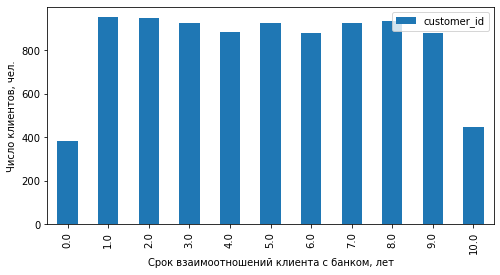

In [17]:
df.pivot_table(index='tenure', values='customer_id', aggfunc='count').plot.bar(figsize=(8,4))
plt.xlabel('Срок взаимоотношений клиента с банком, лет')
plt.ylabel('Число клиентов, чел.')

Интересно, что группы от 1 до 9 лет имеют примерно одинаковый объем клиентов, а новые клиенты и клиенты с 10-летним стажем в 2 раза ниже по количеству. Заменить пропуски на среднее значение кажется неправильным, так как это может сильно исказить выборку.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling
Давайте проверим, может часть пропусков есть в оригинальном источнике. Данные я предварительно сохранила в docs.google:

In [18]:
spreadsheet_id = '10vmWpvCWG8v2ObRbJw0NKQcHH57Ym04Lnzhk3U4QACE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df_original = pd.read_csv(BytesIO(r.content))

In [19]:
display(df_original.info())
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0


Как и ожидалось, пропусков в данных из оригинального источника - нет. Создадим таблицу `tenure` с данными по id клиента и сроке взаимоотношений с банком

In [20]:
tenure = df_original[['CustomerId','Tenure']]
tenure.columns = ['customer_id', 'tenure']
tenure.head()

,customer_id,tenure
0,15634602,2
1,15647311,1
2,15619304,8
3,15701354,1
4,15737888,2


Добавим данные о сроке взаимоотношений клиента с банком по номеру id клиента:

In [21]:
df = df.merge(tenure, on = 'customer_id', how = 'outer')
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure_x,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_y
0,1,15634602,hargrave,619,france,female,42,2.00,0.00,1,1,1,"101,348.88",1,2
1,2,15647311,hill,608,spain,female,41,1.00,"83,807.86",1,0,1,"112,542.58",0,1
2,3,15619304,onio,502,france,female,42,8.00,"159,660.80",3,1,0,"113,931.57",1,8
3,4,15701354,boni,699,france,female,39,1.00,0.00,2,0,0,"93,826.63",0,1
4,5,15737888,mitchell,850,spain,female,43,2.00,"125,510.82",1,1,1,"79,084.10",0,2


Убедимся, что нет ли различий в исходных данных в `df` и добавленных данных по столбцам 'tenure_x' и 'tenure_y':

In [22]:
print('Число совпадающих значений tenure:', df[df['tenure_x']==df['tenure_y']].shape[0])
print('Число совпадающих различий tenure:', df[df['tenure_x']!=df['tenure_y']].shape[0])
df[df['tenure_x']!=df['tenure_y']].head(10)

Число совпадающих значений tenure: 9091
Число совпадающих различий tenure: 909


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure_x,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_y
30,31,15589475,azikiwe,591,spain,female,39,NaN,0.00,3,1,0,"140,469.38",1,3
48,49,15766205,yin,550,germany,male,38,NaN,"103,391.38",1,0,1,"90,878.13",0,2
51,52,15768193,trevisani,585,germany,male,36,NaN,"146,050.97",2,0,0,"86,424.57",0,5
53,54,15702298,parkhill,655,germany,male,41,NaN,"125,561.97",1,0,0,"164,040.94",1,8
60,61,15651280,hunter,742,germany,male,35,NaN,"136,857.00",1,0,0,"84,509.57",0,5
82,83,15641732,mills,543,france,female,36,NaN,0.00,2,0,0,"26,019.59",0,3
85,86,15805254,ndukaku,652,spain,female,75,NaN,0.00,2,1,1,"114,675.75",0,10
94,95,15676966,capon,730,spain,male,42,NaN,0.00,2,0,1,"85,982.47",0,4
99,100,15633059,fanucci,413,france,male,34,NaN,0.00,2,0,0,"6,534.18",0,9
111,112,15665790,rowntree,538,germany,male,39,NaN,"108,055.10",2,1,0,"27,231.26",0,7


Да, действительно, различия между столбцами 'tenure_x' и 'tenure_y' только в пропущенных значениях. Избавимя от ненужного столбца 'tenure_x'. Столбец 'tenure_y' переименуем.

In [23]:
df = df.drop(['tenure_x'], axis=1)

In [24]:
df = df.rename(columns = {'tenure_y': 'tenure'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
 13  tenure            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Посмотрим, как теперь выглядит распределение клиентов по сроку отношений с банком:

In [25]:
df.pivot_table(index='tenure', values='customer_id', aggfunc='count').T

tenure,0,1,2,3,4,5,6,7,8,9,10
customer_id,413,1035,1048,1009,989,1012,967,1028,1025,984,490


Text(0, 0.5, 'Число клиентов, чел.')

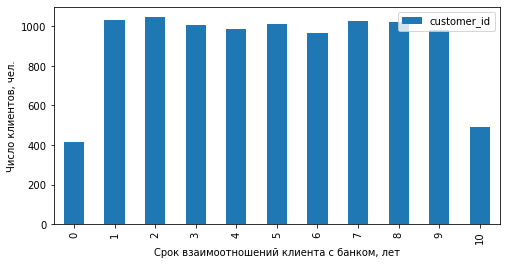

In [26]:
df.pivot_table(index='tenure', values='customer_id', aggfunc='count').plot.bar(figsize=(8,4))
plt.xlabel('Срок взаимоотношений клиента с банком, лет')
plt.ylabel('Число клиентов, чел.')

In [27]:
print('Среднее число лет взаимоотношений с банком:', df['tenure'].mean())

Среднее число лет взаимоотношений с банком: 5.0128


Среднее число лет взаимоотношений с банком осталось на уровне 5 лет. Пропуски заполнились равномерно по всем группам. Группы клиентов с 1-9 годами сохранились похожими по объему, а группы с новыми и 10-летними клиентами остались примерно в 2 раза ниже прочих.

Проверим данные на наличие явных дубликатов:

In [28]:
print('Число явных дубликатов:', df.duplicated().sum())

Число явных дубликатов: 0


Проверим наличие дубликатов без учета первых двух столбцов: 

- первый столбец (порядковый номер записи), 
- второй столбец (id клиента) отбросим на случай ошибочного внесения одного клиента под разными id.

In [29]:
print('Число явных дубликатов без учета row_number и customer_id:', 
      df.drop(['row_number', 'customer_id'], axis=1).duplicated().sum())

Число явных дубликатов без учета row_number и customer_id: 0


*Выводы*

В ходе предобработки данных проделано следующее:
- текстовые значения приведены к нижнему регистру,
- наименования столбцов приведены к "змеиному регистру",
- заполнены пропуски данных о сроке взаимоотношений клиента с банком (столбец "tenure"),
- дубликаты в данных не выявлены.

### 1.3. Подготовка признаков для моделирования

Зафиксируем признаки, которые следует использовать при построении моделей:
- exited (*целевой признак*),
- credit_score,
- geography,
- gender,
- age,
- balance,
- num_of_products,
- has_cr_card,
- is_active_member,
- estimated_salary,
- tenure.

Незначимые признаки, которые не будем использовать в анализе:
- row_number (индекс строки в данных), 
- customer_id (уникальный идентификатор клиента), 
- surname (фамилия клиента).

Для начала преобразуем с помощью One-Hot Encoding категориальные признаки в численные:
- geography,
- gender.

Для начала создадим новый датафрейм `df_analize`, в котором оставим только нужные нам признаки:

In [30]:
df_analize = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [31]:
df_analize = pd.get_dummies(df_analize, drop_first=True)
df_analize.head()

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure,geography_germany,geography_spain,gender_male
0,619,42,0.00,1,1,1,"101,348.88",1,2,0,0,0
1,608,41,"83,807.86",1,0,1,"112,542.58",0,1,0,1,0
2,502,42,"159,660.80",3,1,0,"113,931.57",1,8,0,0,0
3,699,39,0.00,2,0,0,"93,826.63",0,1,0,0,0
4,850,43,"125,510.82",1,1,1,"79,084.10",0,2,0,1,0


Теперь все признаки представлены в числовом формате.

Для дальнейшего иследования разделим исходные данные на 3 выборки:
- обучающая выборка `train` (60% исходных данных),
- валидационная выборка `valid` (20% исходных данных),
- тестовая выборка `test`(20% исходных данных).

Для начала отделим `train`, оставшиеся данные запишем в `valid_test`:

In [32]:
target = df_analize['exited']
features = df_analize.drop('exited', axis=1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

Теперь разделим выборки `valid_test` на `valid` и `test`

In [33]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)
print('Число наблюдений в обучающей выборке:', features_train.shape[0])
print('Число наблюдений в валидационной выборке:', features_valid.shape[0])
print('Число наблюдений в тестовой выборке:', features_test.shape[0])

Число наблюдений в обучающей выборке: 6000
Число наблюдений в валидационной выборке: 2000
Число наблюдений в тестовой выборке: 2000


У количественных признаков 'credit_score', 'age', 'balance', 'estimated_salary', 'num_of_products', 'tenure' разный масштаб. Поэтому стандартизируем их с помощью StandardScaler.



In [34]:
numeric = ['credit_score', 'age', 'balance', 'estimated_salary', 'num_of_products', 'tenure'] # список количественных признаков
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]= scaler.transform(features_train[numeric])
features_valid[numeric]= scaler.transform(features_valid[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])

# первые 5 строк обучающей выборки
features_train.head()

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,tenure,geography_germany,geography_spain,gender_male
2837,-1.04,0.95,0.77,-0.91,0,1,-0.12,0.34,1,0,0
9925,0.45,-0.10,1.91,-0.91,1,1,-0.26,-0.01,0,0,0
8746,0.10,-0.48,0.48,0.82,0,1,1.42,1.03,0,0,1
660,-0.18,0.19,0.09,-0.91,1,1,-1.16,-0.70,1,0,0
3610,-0.72,1.62,0.88,-0.91,1,0,0.11,-1.39,0,0,0


*Выводы*

Признаки для построения модели подготовлены: категориальные переведены в численные, произведено масштабирование количественных признаков. Данные разделены на обучающую `train`, валидационную `valid` и тестовую `test` выборки.

## 2. Исследование задачи

Исследуем баланс классов по целевому признаку (exited): класс с меткой «1» называется положительным, с меткой «0» — отрицательным. При разделении данных на несколько выборок мы использовали параметр "stratify", поэтому доля ушедших клиентов должна быть примерно одинаковой во всех выборках.

In [35]:
print(f'Доля ушедших клиентов во всем датасете: {round(target.mean()*100,1)}%')
print(f'Доля ушедших клиентов в обучающей выборке: {round(target_train.mean()*100,1)}%')
print(f'Доля ушедших клиентов в валидационной выборке: {round(target_valid.mean()*100,1)}%')
print(f'Доля ушедших клиентов в тестовой выборке: {round(target_test.mean()*100,1)}%')

Доля ушедших клиентов во всем датасете: 20.4%
Доля ушедших клиентов в обучающей выборке: 20.4%
Доля ушедших клиентов в валидационной выборке: 20.4%
Доля ушедших клиентов в тестовой выборке: 20.3%


Наблюдается дисбаланс классов: положительный класс в 4 раза меньше отрицательного.

Построим модели классификации без учета дисбаланса (imbalance) классов: логистическую регрессию `model_regres_imb`, случайный лес `model_forest_imb`, дерево решений `model_tree_imb`.

### 2.1. Дерево решений

Построим дерево решений `model_tree_imb` с выбором оптимальной глубины в диапазоне от 1 до 10. Для выбора отимальной глубины будем ориентироваться на максимальное значение F1-меры.

In [138]:
model_tree_imb = None
f_score_tree = 0
depth_tree = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=0, max_depth=depth) # модель с заданной глубиной дерева
    model.fit(features_train, target_train)
    f_score = f1_score(target_valid, model.predict(features_valid))
    if f_score > f_score_tree:
        model_tree_imb = model
        f_score_tree = f_score
        depth_tree = depth

print("Значение F1-меры лучшей модели дерева решений на валидационной выборке:", f_score_tree)
print("Глубина лучшей модели дерева решений:", depth_tree)

Значение F1-меры лучшей модели дерева решений на валидационной выборке: 0.5953757225433526
Глубина лучшей модели дерева решений: 7


In [140]:
ra_dt = roc_auc_score(target_valid, (model_tree_imb.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_dt)

Значение AUC-ROC на валидационной выборке: 0.8262436570105429


### 2.2. Случайный лес

Построим в цикле модель случайного леса `model_forest_imb` с выбором оптимального количества деревьев (от 90 до 110 с шагом 2) и оптимальной глубины (от 1 до 10) по значению F1-меры:

In [141]:
model_forest_imb = None
f_score_forest = 0
estimators_forest = 0
depth_forest = 0
for est in range(90, 111, 2):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        f_score = f1_score(target_valid, model.predict(features_valid))
        if f_score > f_score_forest:
            model_forest_imb = model
            f_score_forest = f_score
            estimators_forest = est
            depth_forest = depth

print("Значение F1-меры лучшей модели случайного леса на валидационной выборке:", f_score_forest)
print("Количество деревьев лучшей модели случайного леса:", estimators_forest)
print("Глубина лучшей модели случайного леса:", depth_forest)

Значение F1-меры лучшей модели случайного леса на валидационной выборке: 0.5811437403400309
Количество деревьев лучшей модели случайного леса: 108
Глубина лучшей модели случайного леса: 10


In [142]:
ra_rf = roc_auc_score(target_valid, (model_forest_imb.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_rf)

Значение AUC-ROC на валидационной выборке: 0.8712034436890335


### 2.3. Логистическая регрессия

Построим логистическую регрессию `model_regres_imb`

In [143]:
model_regres_imb = LogisticRegression(random_state=0, solver='liblinear')
model_regres_imb.fit(features_train, target_train)
f_score_regres = f1_score(target_valid, model_regres_imb.predict(features_valid))
print("Значение F1-меры логистической регрессии на валидационной выборке:", f_score_regres)

ra_lr = roc_auc_score(target_valid, (model_regres_imb.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_lr)

Значение F1-меры логистической регрессии на валидационной выборке: 0.3076923076923077
Значение AUC-ROC на валидационной выборке: 0.7874113213124446


*Выводы*

Худшей моделью оказалась логистическая регрессия. Лучшей моделью классификации без учета дисбаланса классов стала модель случайного леса `model_forest_imb` с 11 деревьями. Значение F1-меры = 0.6262 для такой модели, AUC-ROC = 0.8438.

## 3. Борьба с дисбалансом

Ранее мы отмечали, что в данных есть дисбаланс: число наблюдений положительного класса (ушедшие клиенты) в 4 раза меньше числа наблюдений отрицательного класса.

Для борьбы с дисбалансом будем использовать 3 способа:

1. Использование параметра class_weight
2. Увеличение выборки (upsampling)
3. Уменьшение выборки (downsampling)

### 3.1. Использование параметра class_weight

Построим те же модели, что и в предыдущем разделе, но с учетом параметра `class_weight='balanced'`.

*1. **Дерево решений** `model_tree_cw` с выбором глубины в диапазоне от 1 до 10*

In [144]:
model_tree_cw = None
f_score_tree_cw = 0
depth_tree_cw = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=0, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    f_score = f1_score(target_valid, model.predict(features_valid))
    if f_score > f_score_tree_cw:
        model_tree_cw = model
        f_score_tree_cw = f_score
        depth_tree_cw = depth

print("Значение F1-меры лучшей модели дерева решений на валидационной выборке:", f_score_tree_cw)
print("Глубина лучшей модели дерева решений:", depth_tree_cw)

ra_dt_cw = roc_auc_score(target_valid, (model_tree_cw.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_dt_cw)

Значение F1-меры лучшей модели дерева решений на валидационной выборке: 0.5764596848934197
Глубина лучшей модели дерева решений: 6
Значение AUC-ROC на валидационной выборке: 0.8277116279929057


*2. **Случайный лес** `model_forest_cw` с количеством деревьев от 90 до 110 с шагом 2 c глубиной от 1 до 10*

In [145]:
model_forest_cw = None
f_score_forest_cw = 0
estimators_forest_cw = 0
depth_forest_cw = 0
for est in range(90, 111, 2):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth, class_weight='balanced') 
        model.fit(features_train, target_train)
        f_score = f1_score(target_valid, model.predict(features_valid))
        if f_score > f_score_forest_cw:
            model_forest_cw = model
            f_score_forest_cw = f_score
            estimators_forest_cw = est
            depth_forest_cw = depth

print("Значение F1-меры лучшей модели случайного леса на валидационной выборке:", f_score_forest_cw)
print("Количество деревьев лучшей модели случайного леса:", estimators_forest_cw)
print("Глубина лучшей модели случайного леса:", depth_forest_cw)

ra_rf_cw = roc_auc_score(target_valid, (model_forest_cw.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_rf_cw)

Значение F1-меры лучшей модели случайного леса на валидационной выборке: 0.6446644664466448
Количество деревьев лучшей модели случайного леса: 94
Глубина лучшей модели случайного леса: 8
Значение AUC-ROC на валидационной выборке: 0.8706445832101685


*3. **Логистическая регрессия** `model_regres_cw`*

In [146]:
model_regres_cw = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced')
model_regres_cw.fit(features_train, target_train)
f_score_regres_cw = f1_score(target_valid, model_regres_cw.predict(features_valid))
print("Значение F1-меры логистической регрессии на валидационной выборке:", f_score_regres_cw)

ra_lr_cw = roc_auc_score(target_valid, (model_regres_cw.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_lr_cw)

Значение F1-меры логистической регрессии на валидационной выборке: 0.5299295774647889
Значение AUC-ROC на валидационной выборке: 0.7936419228495418


*Выводы*

Параметр class_weight='balanced' помог улучшить значение F1-меры логистической регрессии с 0.31 до 0.53, случайного леса с 0.58 до 0.64. В дереве решений значение F1-меры снизилось с 0.6 до 0.58.
Худшей моделью осталась логистическая регрессия. Лучшей моделью классификации с параметром class_weight='balanced' стала модель случайного леса model_forest_imb с 94 деревьями и глубиной =8. Значение F1-меры = 0.64 для такой модели, ROC-AUC = 0.87.

### 3.2. Увеличение выборки (upsampling)

Класс "1" меньше класса "0" в 4 раза, поэтому будем увеличивать его объем. Зададим разделение классов:

In [147]:
features_1 = features_train[target_train==1]
features_0 = features_train[target_train==0]
target_1 = target_train[target_train==1]
target_0 = target_train[target_train==0]

Создадим новые признаки, увеличив объем класса "1" в 4 раза:

In [148]:
features_upsampled = pd.concat([features_0] + [features_1]*4)
target_upsampled = pd.concat([target_0] + [target_1]*4)
# перемешаем данные
features_upsampled, target_upsampled = shuffle (features_upsampled, target_upsampled, random_state=0)
print('Число наблюдений в увеличенной обучающей выборке:', features_upsampled.shape[0])

Число наблюдений в увеличенной обучающей выборке: 9666


Построим те же три модели, что и в предыдущем разделе, но с учетом увеличенной выборки.

*1. **Дерево решений** `model_tree_up` с выбором глубины в диапазоне от 1 до 10*

In [150]:
model_tree_up = None
f_score_tree_up = 0
depth_tree_up = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=0, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    f_score = f1_score(target_valid, model.predict(features_valid))
    if f_score > f_score_tree_up:
        model_tree_up = model
        f_score_tree_up = f_score
        depth_tree_up = depth

print("Значение F1-меры лучшей модели дерева решений на валидационной выборке:", f_score_tree_up)
print("Глубина лучшей модели дерева решений:", depth_tree_up)

ra_dt_up = roc_auc_score(target_valid, (model_tree_up.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_dt_up)

Значение F1-меры лучшей модели дерева решений на валидационной выборке: 0.5764596848934197
Глубина лучшей модели дерева решений: 6
Значение AUC-ROC на валидационной выборке: 0.827727023598384


*2. **Случайный лес** `model_forest_up` с количеством деревьев от 90 до 110 с шагом 2 c глубиной от 1 до 10*

In [151]:
model_forest_up = None
f_score_forest_up = 0
estimators_forest_up = 0
depth_forest_up = 0
for est in range(90, 111, 2):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth) 
        model.fit(features_upsampled, target_upsampled)
        f_score = f1_score(target_valid, model.predict(features_valid))
        if f_score > f_score_forest_up:
            model_forest_up = model
            f_score_forest_up = f_score
            estimators_forest_up = est
            depth_forest_up = depth

print("Значение F1-меры лучшей модели случайного леса на валидационной выборке:", f_score_forest_up)
print("Количество деревьев лучшей модели случайного леса:", estimators_forest_up)
print("Глубина лучшей модели случайного леса:", depth_forest_up)

ra_rf_up = roc_auc_score(target_valid, (model_forest_up.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_rf_up)

Значение F1-меры лучшей модели случайного леса на валидационной выборке: 0.643956043956044
Количество деревьев лучшей модели случайного леса: 102
Глубина лучшей модели случайного леса: 10
Значение AUC-ROC на валидационной выборке: 0.8707184821164646


*3. **Логистическая регрессия** `model_regres_up`*

In [152]:
model_regres_up = LogisticRegression(random_state=0, solver='liblinear')
model_regres_up.fit(features_upsampled, target_upsampled)
f_score_regres_up = f1_score(target_valid, model_regres_up.predict(features_valid))
print("Значение F1-меры логистической регрессии на валидационной выборке:", f_score_regres_up)

ra_lr_up = roc_auc_score(target_valid, (model_regres_up.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_lr_up)

Значение F1-меры логистической регрессии на валидационной выборке: 0.5233968804159445
Значение AUC-ROC на валидационной выборке: 0.7937081239530989


### 3.3. Уменьшение выборки (downsampling)

Создадим новые признаки, уменьшив объем класса "0" в 4 раза:

In [153]:
features_downsampled = pd.concat([features_0.sample(frac=0.25, random_state=0)] + [features_1])
target_downsampled = pd.concat([target_0.sample(frac=0.25, random_state=0)] + [target_1])
# перемешаем данные
features_downsampled, target_downsampled = shuffle (features_downsampled, target_downsampled, random_state=0)
print('Число наблюдений в уменьшенной обучающей выборке:', features_downsampled.shape[0])

Число наблюдений в уменьшенной обучающей выборке: 2416


Построим те же три модели, что и в предыдущем разделе, но с учетом увеличенной выборки.

*1. **Дерево решений** `model_tree_down` с выбором глубины в диапазоне от 1 до 10*

In [154]:
model_tree_down = None
f_score_tree_down = 0
depth_tree_down = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=0, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    f_score = f1_score(target_valid, model.predict(features_valid))
    if f_score > f_score_tree_down:
        model_tree_down = model
        f_score_tree_down = f_score
        depth_tree_down = depth

print("Значение F1-меры лучшей модели дерева решений на валидационной выборке:", f_score_tree_down)
print("Глубина лучшей модели дерева решений:", depth_tree_down)

ra_dt_down = roc_auc_score(target_valid, (model_tree_down.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_dt_down)

Значение F1-меры лучшей модели дерева решений на валидационной выборке: 0.5785582255083179
Глубина лучшей модели дерева решений: 5
Значение AUC-ROC на валидационной выборке: 0.8378280803527441


*2. **Случайный лес** `model_forest_down` с количеством деревьев от 90 до 110 с шагом 2 и глубиной от 1 до 10*

In [155]:
model_forest_down = None
f_score_forest_down = 0
estimators_forest_down = 0
depth_forest_down = 0
for est in range(90, 111, 2):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=0, n_estimators=est, max_depth=depth) 
        model.fit(features_downsampled, target_downsampled)
        f_score = f1_score(target_valid, model.predict(features_valid))
        if f_score > f_score_forest_down:
            model_forest_down = model
            f_score_forest_down = f_score
            estimators_forest_down = est
            depth_forest_down = depth

print("Значение F1-меры лучшей модели случайного леса на валидационной выборке:", f_score_forest_down)
print("Количество деревьев лучшей модели случайного леса:", estimators_forest_down)
print("Глубина лучшей модели случайного леса:", depth_forest_down)

ra_rf_down = roc_auc_score(target_valid, (model_forest_down.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_rf_down)

Значение F1-меры лучшей модели случайного леса на валидационной выборке: 0.6195028680688336
Количество деревьев лучшей модели случайного леса: 110
Глубина лучшей модели случайного леса: 7
Значение AUC-ROC на валидационной выборке: 0.8708447260813872


*3. **Логистическая регрессия** `model_regres_down`*

In [156]:
model_regres_down = LogisticRegression(random_state=0, solver='liblinear')
model_regres_down.fit(features_downsampled, target_downsampled)
f_score_regres_down = f1_score(target_valid, model_regres_down.predict(features_valid))
print("Значение F1-меры логистической регрессии на валидационной выборке:", f_score_regres_down)

ra_lr_down = roc_auc_score(target_valid, (model_regres_down.predict_proba(features_valid)[:,1]))
print("Значение AUC-ROC на валидационной выборке:", ra_lr_down)

Значение F1-меры логистической регрессии на валидационной выборке: 0.5231560891938251
Значение AUC-ROC на валидационной выборке: 0.7923409941866194


## 4. Выбор лучшей модели

Выберем лучшую модель по значение F1-меры. Для начала создадим датафрейм `f_score` со значениями F1-меры всех построенных моделей:

In [157]:
f_score = pd.DataFrame({'imbalance': [f_score_tree, f_score_forest, f_score_regres],
                        'class_weight': [f_score_tree_cw, f_score_forest_cw, f_score_regres_cw],
                        'upsampling': [f_score_tree_up, f_score_forest_up, f_score_regres_up],
                        'downsampling': [f_score_tree_down, f_score_forest_down, f_score_regres_down]},
                index= ['decision_tree', 'random_forest', 'logistic_regression'])
f_score

,imbalance,class_weight,upsampling,downsampling
decision_tree,0.60,0.58,0.58,0.58
random_forest,0.58,0.64,0.64,0.62
logistic_regression,0.31,0.53,0.52,0.52


Максимальные значения F1-меры для каждой модели:

In [158]:
f_score.idxmax(axis=1)

decision_tree             imbalance
random_forest          class_weight
logistic_regression    class_weight
dtype: object

Создадим датафрейм `roc_auc` со значениями ROC-AUC на валидации всех построенных моделей:

In [159]:
roc_auc = pd.DataFrame({'imbalance': [ra_dt, ra_rf, ra_lr],
                        'class_weight': [ra_dt_cw, ra_rf_cw, ra_lr_cw],
                        'upsampling': [ra_dt_up, ra_rf_up, ra_lr_up],
                        'downsampling': [ra_dt_down, ra_rf_down, ra_lr_down]},
                index= ['decision_tree', 'random_forest', 'logistic_regression'])
roc_auc

,imbalance,class_weight,upsampling,downsampling
decision_tree,0.83,0.83,0.83,0.84
random_forest,0.87,0.87,0.87,0.87
logistic_regression,0.79,0.79,0.79,0.79


Максимальные значения ROC-AUC для каждой модели:

In [160]:
roc_auc.idxmax(axis=1)

decision_tree          downsampling
random_forest             imbalance
logistic_regression      upsampling
dtype: object

*Выводы*

Таким образом, моделью с наилучшими значениями F1-меры = 0.645 на валидационной выборке является модель случайного леса с 94 деревом и глубиной = 8, построенная с применением параметра 'class_weight'. Значение AUC-ROC для этой модели = 0.871.

## 5. Тестирование лучшей модели

Моделью с наилучшими значениями F1-меры на валидационной выборке является модель случайного леса с 94 деревом и глубиной = 8, построенная с применением  параметра 'class_weight'. 
Проверим модель `model_forest_cw` на тестовой выборке:

In [164]:
print("Значение F1-меры лучшей модели случайного леса на тестовой выборке:", 
     f1_score(target_test, model_forest_cw.predict(features_test)))

Значение F1-меры лучшей модели случайного леса на тестовой выборке: 0.604026845637584


Построим ROC-кривую для тестовой выборки и рассчитаем значение AUC-ROC:

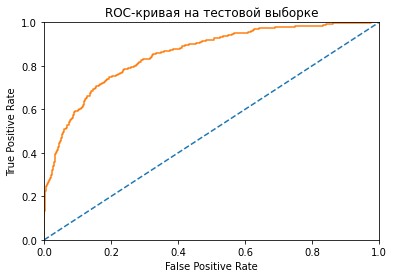

Значение ROC-AUC на тестовой выборке: 0.8542548712040239


In [165]:
fpr, tpr, thresholds = roc_curve(target_test, 
                                 (model_forest_cw.predict_proba(features_test)[:,1]))

plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.show()

print("Значение ROC-AUC на тестовой выборке:", 
      roc_auc_score(target_test, (model_forest_cw.predict_proba(features_test)[:,1])))

Попробуем улучшить качество, обучив модель `model_forest_cw` на объединенной выборке обучающих и валидационных признаков. Обученную модель перезапишем в переменную `model_best`:

In [170]:
features_best = pd.concat([features_upsampled] + [features_valid]) # объединение выборок
target_best = pd.concat([target_upsampled] + [target_valid]) # объединение выборок
model_best = model_forest_cw 
model_best.fit(features_best, target_best)

print("Accuracy лучшей модели на тестовой выборке:", model_best.score(features_test,target_test))
print("Precision лучшей модели на тестовой выборке:", precision_score(target_test, model_best.predict(features_test)))
print("Recall лучшей модели на тестовой выборке:", recall_score(target_test, model_best.predict(features_test)))
print("Значение F1-меры лучшей модели на тестовой выборке:", f1_score(target_test, model_best.predict(features_test)))

Accuracy лучшей модели на тестовой выборке: 0.816
Precision лучшей модели на тестовой выборке: 0.5365853658536586
Recall лучшей модели на тестовой выборке: 0.7027027027027027
Значение F1-меры лучшей модели на тестовой выборке: 0.6085106382978724


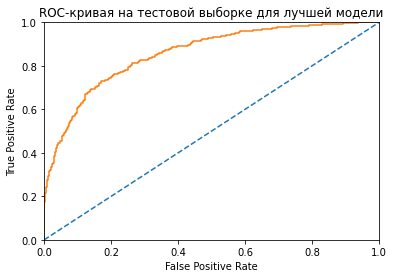

Значение AUC-ROC на тестовой выборке: 0.8568784500987889


In [171]:
fpr_best, tpr_best, thresholds_best = roc_curve(target_test, 
                                 (model_best.predict_proba(features_test)[:,1]))

plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.plot(fpr_best, tpr_best)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке для лучшей модели')
plt.show()

print("Значение AUC-ROC на тестовой выборке:", 
      roc_auc_score(target_test, (model_best.predict_proba(features_test)[:,1])))

*Вывод*

Качество модели на тестовых данных улучшилось после обучения на объединенной выборке: F1-мера лучшей модели выросла с 0.604 до 0.609, значение AUC-ROC на тестовой выборке выросло с 0.854 до 0.857.

## 6. Общий вывод

В ходе исследования были изучены данные о поведении клиентов «Бета-Банка» и расторжении ими договоров.

Для решения задачи классификации, которая будет предсказывать уход клиента, были использованы 3 метода классификации: дерево решений, случайный лес и логистическая регрессия. 

Так как исходные данные не были сбалансированными (класс ушедших клиентов в 4 раза меньше класса оставшихся), при построении моделей были протестированы различные методы борьбы с дисбалансом классов: использование параметра class_weight, увеличение выборки (upsampling), уменьшение выборки (downsampling).

В общей сложности было протестировано (без учета дисбаланса и с тремя методами борьбы с дисбалансом):
- 40 моделей дерева решений (глубина от 1 до 10), 
- 400 моделей случайного леса (число деревьев от 90 до 110 с шагом 2, глубина от 1 до 10), 
- 4 модели логистической регресии.

Наилучшее качество показала модель случайного леса `model_best` с 94 деревом и глубиной = 8, построенная с применением параметра 'class_weight'. 
- Accuracy лучшей модели на тестовой выборке: 0.816
- Precision лучшей модели на тестовой выборке: 0.537
- Recall лучшей модели на тестовой выборке: 0.703
- Значение F1-меры лучшей модели на тестовой выборке: 0.609
- Значение AUC-ROC на тестовой выборке: 0.857